# Shopify Data Science Internship Challenge
## By Reid Witzel

# Q1: Sneaker Shops and Averages

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.

## Q1a: Think about what could be going wrong with our calculation

The primary risk of using the mean as a measure of the typical value of a dataset is that it can be heavily skewed by outliers – maybe this is going on here.

In order to validate this hypothesis, let’s first explore the data and then generate a histogram of the order values.


In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read dataset

shop = pd.read_csv('Shop.csv')

   ### Q1a Exploring the dataset

In [3]:
shop.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [4]:
shop.order_amount.describe()

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

Above we've gotten our first piece of evidence in favour of our hypothesis that the data are being skewed by outliers - the 75th percentile order amount is 390, and yet the mean is over 3,000! We can also see that the max is 704,000 - this is more than 1,000 times the 75th percentile of the data! Finally, the standard deviation is much, much larger than the mean, which further suggests that the outliers are responsible for skewing the mean.

How steep is the climb from "regular" orders to these huge orders? To answer that, we'll take a look at some percentile intervals at the top end of the range:

In [5]:
percentile = [0.9,0.95,0.98,0.985,0.99,0.995,0.999]

shop.order_amount.describe(percentiles = percentile)

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
50%         284.000000
90%         531.000000
95%         640.000000
98%         800.080000
98.5%       948.180000
99%       25725.000000
99.5%     77175.000000
99.9%    704000.000000
max      704000.000000
Name: order_amount, dtype: float64

We can see above that there is a **significant jump** in the magnitude of the orders in the **top 1.5 percentile**. Up to the 98.5 percentile, orders range from 90 to 948, and yet the top 1% ranges from 25,725 to 704,000!

Let's take a look at a logarithmic bar chart of our numbers to get a sense of the scale of these outliers:

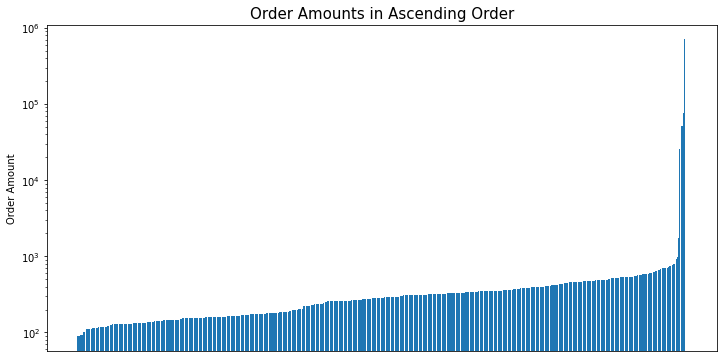

In [6]:
order_amounts = shop.order_amount.sort_values(ascending = True)

x = pd.Series(range(1, len(order_amounts) + 1 ,1))

plt.figure(figsize = (12,6))
plt.bar(x,order_amounts, log=True)
plt.ylabel('Order Amount')
plt.title('Order Amounts in Ascending Order', fontsize = 15)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.show()

From the log chart, we can see that the vast majority of our values are under 1,000, with a rapid spike towards the top end of the values of nearly 3 orders of magnitude.

### Q1a Histogram

Now that we have a sense of how anomalous the upper range is, we can can get a better sense of what the distribution of "normal" orders looks like. We'll use a histogram of all orders under \\$1,000 to visualize the distribution, as well as give us an intuition for what a typical value looks like.

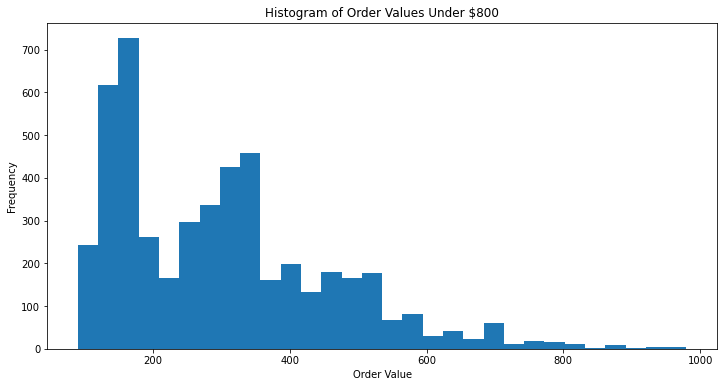

In [7]:
plt.figure(figsize=(12,6))

plt.hist(shop[shop['order_amount']<1000]['order_amount'], bins = 30)
plt.xlabel('Order Value')
plt.ylabel('Frequency')
plt.title('Histogram of Order Values Under $800')
plt.show()

By removing the long tail, we can get a much better idea of the shape of our distribution. There are two peaks, one between 120 and 180, and another between 260 and 360. There is a third small peak just shy of 500.


One possible explanation for the peaks in this distribution is that the typical sale price of a sneaker is between 120 and 180, and that the most common order quantity is a single pair, followed by two pairs, followed by three pairs. It's an interesting question but not the focus of this exercise!

### Q1a Conclusion

We've seen from the quartile breakdown and logarithmic bar chart that the **mean** has been **skewed** by a the top 1.5% of values, which are significantly larger than the remaining 98.5%. The problem with the calculation is that the mean of a sample does not account properly for outliers and allows them to exert a strong effect.

Our histogram shows that most "normal" orders have a value between 80 and about 600, with the typical value somewhere around 250. 

## Q1b: What metric would I report for this dataset?

There are two choices of an alternative metric for summarizing the data that come to mind: the median and the mode. Both of these solve our problem of outliers, but I believe that **the median is the better choice.**

The median indicates a typical value at the center of the ordered dataset and is thus completely free from influence of outliers. Medians are commonly used for summarizing data with long tails, such as the typical income of a population, and so it seems like it could be a good fit here.

The mode would tell us the most common order value, but with continuous data such as we see in this dataset the mode is unlikely to truly represent a typical value.

## Q1c: What is the value of the metric in question?

Let's calculate both the median and the mean, then compare the results with the histogram above to see intuitively if these metrics are effective in representing a typical order size.

In [8]:
median = shop.order_amount.median()

print(median)

284.0


In [9]:
# Use value_counts function to return the top 10 most common values of order amount

mode = shop.order_amount.value_counts().head(5)

print(mode)

153    87
306    85
354    82
312    75
156    75
Name: order_amount, dtype: int64


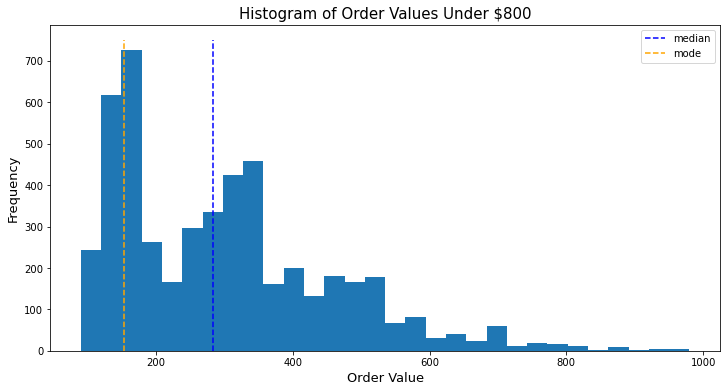

In [10]:
# Plot the median and mode on top of the histogram from earlier

plt.figure(figsize=(12,6))

plt.hist(shop[shop['order_amount']<1000]['order_amount'], bins = 30)
plt.xlabel('Order Value', fontsize = 13)
plt.ylabel('Frequency', fontsize = 13)
plt.title('Histogram of Order Values Under $800', fontsize = 15)
plt.vlines(median, 0, 750, color = "blue", linestyles = "dashed", label = "median")
plt.vlines(mode.index[0], 0, 750, color = "orange", linestyles = "dashed", label = "mode")
plt.legend()
plt.show()

#### **The median is 284**, which represents a typical order value. If we refer back to the histogram we generated, this seems like a reasonable number to describe what a typical shopper purchases on Shopify's 100 sneaker shops.

**The mode is 153.** Again, referring back to the histogram, this is not a very representative number. We have nearly as many orders clustered around 300 as around 150. It's important to note also that 306 and 354 have nearly as many instances in our dataset as 153 does - the mode is not giving us a very clear picture of the typical value!

### Q1c Conclusion

The **median** looks to be the best indicator of what a typical order size might be, with a value of **284** for this dataset.

----------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------

# Q2: SQL Queries

For this question we’ll need to use SQL. [Follow this link](https://www.w3schools.com/SQL/TRYSQL.ASP?FILENAME=TRYSQL_SELECT_ALL) to access the data set required for the challenge. The queries used are pasted below along with the output from each query. 

## Q2a: How many orders were shipped by Speedy Express in total?

### Q2a Code

--  *Join Shippers and Orders; print count of OrderID grouped by ShipperName:*

SELECT S.ShipperName as "Shipper Name", COUNT(O.OrderID) as "Order Count"  
FROM Shippers as S

INNER JOIN Orders as O on S.ShipperID = O.ShipperID  
GROUP BY (S.ShipperName)  
;

### Q2a Output

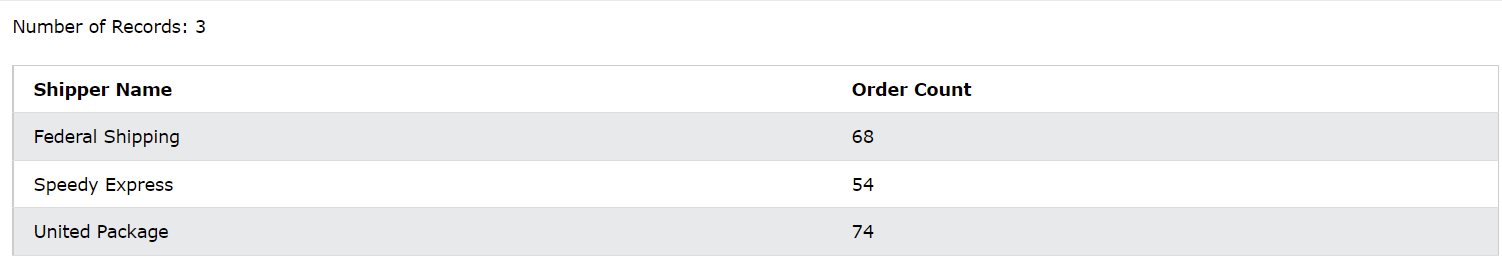

### Q2a Conclusion

From the above output, we can see that **Speedy Express** shipped **54 orders.**

## Q2b: What is the last name of the employee with the most orders?


### Q2b Code

-- *Join Employees table with Orders table, summarize count of orders by EmployeeID and display the LastName for each corresponding EmployeeID*
 
SELECT Orders.EmployeeID, LastName, COUNT(OrderID)  
FROM Employees   
INNER JOIN Orders ON Employees.EmployeeID = Orders.EmployeeID  

GROUP BY Orders.EmployeeID  
ORDER BY COUNT(OrderID) DESC  
;

### Q2b Output

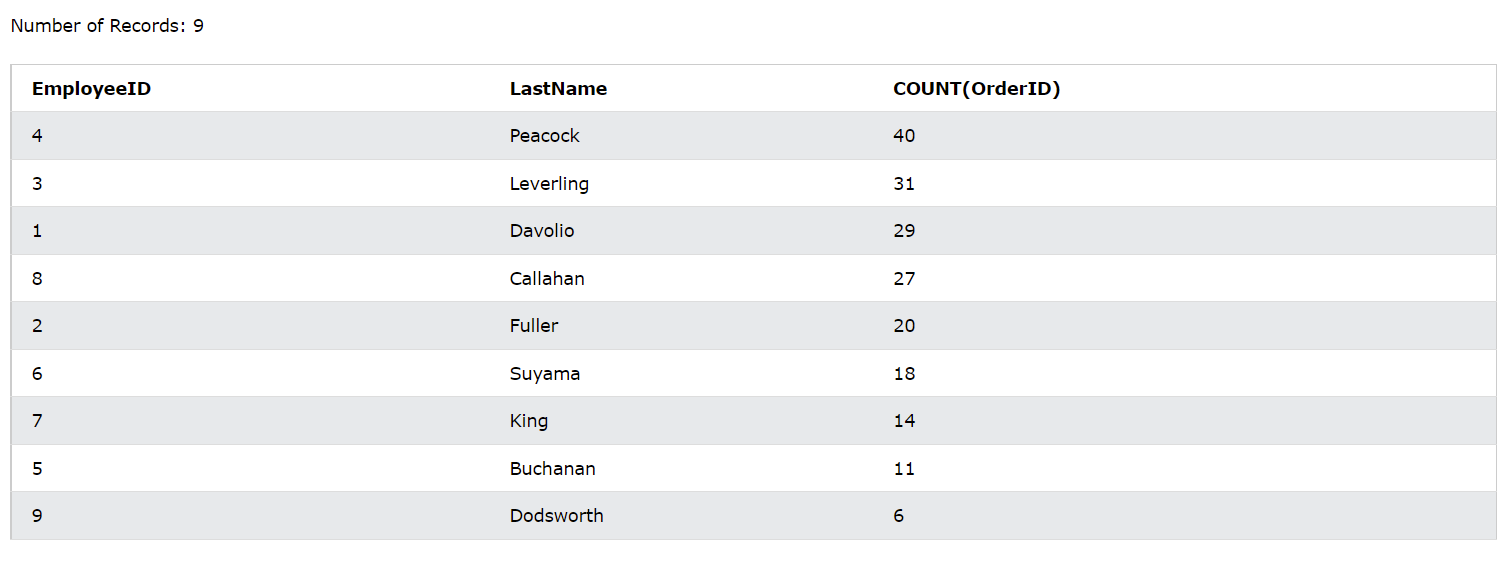

### Q2b Conclusion

**Peacock** has the **most orders** in the system, with almost 30% more than the next highest. It would be interesting to know if Peacock is bringing in more revenue than the others and their orders are simply smaller, or if they are truly outperforming their peers by 30%. 

## Q2c: What product was ordered the most by customers in Germany?

### Q2c Code

/* *Join Customers, Orders, OrderDetails and Product together using the various ID’s as keys, then sum order quantities grouped by product ID’s where country is equal to Germany.* /*

SELECT P.ProductName, OD.ProductID, SUM(OD.Quantity) as Quantity  
FROM Customers AS C
 
INNER JOIN Orders as O on C.CustomerID = O.CustomerID  
INNER JOIN OrderDetails as OD on O.OrderID = OD.OrderID  
INNER JOIN Products as P on OD.ProductID = P.ProductID  
 
WHERE C.Country = "Germany"  
GROUP BY OD.ProductID  
ORDER BY SUM(OD.Quantity) DESC  
LIMIT 10  
;

### Q2c Output

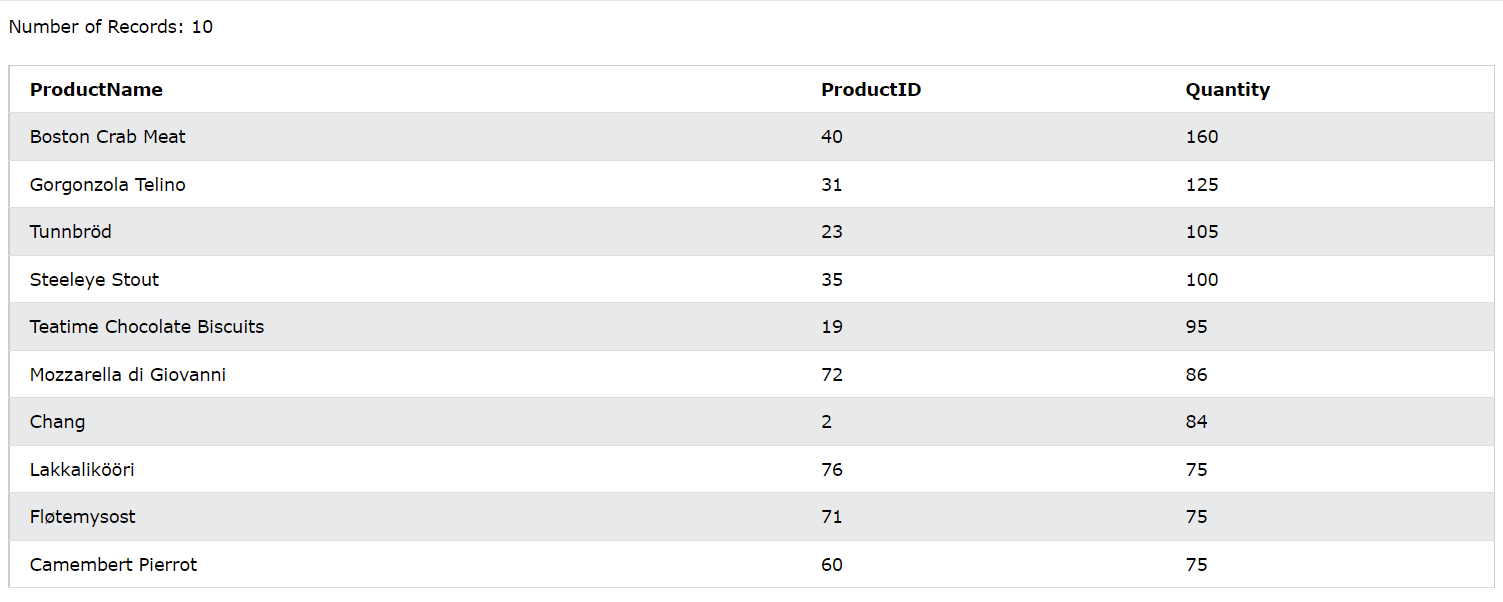

### Q2c Conclusion

**Boston Crab Meat** was the **most ordered product in Germany**. Note that this does not suggest anything about revenue generated, only the number of products sold.